In [ ]:
import scanpy as sc
import numpy as np
import os
import anndata2ri
import pathlib
import scvelo as scv
from scipy import io
import anndata#
import pandas as pd
from tqdm import tqdm
import argparse
import sys
import re
# Activate the anndata2ri conversion between SingleCellExperiment and AnnData
anndata2ri.activate()

#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
%load_ext rpy2.ipython

sc.settings.verbosity = 3
# sc.logging.print_versions()

import warnings
warnings.filterwarnings("ignore")
PROJECT = "SBharadwaj_20240318"
outdir = os.path.join("/media/hieunguyen/HD01/outdir/CRC1382", PROJECT)

path_to_main_src = "/home/hieunguyen/CRC1382/src_2023/SBharadwaj/deep_seq_batch"
samplesheet = pd.read_csv(os.path.join(path_to_main_src, "SampleSheet_for_DGE_and_CellChat.csv"))
samplesheet["full_dataset_name"] = samplesheet[["PROJECT", "dataset_name"]].apply(
    lambda x: f"{x[0]}_{x[1]}", axis = 1
)
samplesheet = samplesheet[~samplesheet["full_dataset_name"].duplicated()]

full_name = "SBharadwaj_20240318_Sample_1_4_7_8_2_5_full"
print(f"Working on dataset {full_name}")

#####------------------------------------------------------------#####
##### Read anndata
#####------------------------------------------------------------#####
project = samplesheet[samplesheet["full_dataset_name"] == full_name]["PROJECT"].values[0]
dataset_name = samplesheet[samplesheet["full_dataset_name"] == full_name]["dataset_name"].values[0]
path_to_input_s_obj = samplesheet[samplesheet["full_dataset_name"] == full_name]["path"].values[0]
path_to_main_output = os.path.join(outdir, project, "data_analysis")

path_to_seurat2anndata = os.path.join(path_to_main_output, "09_output", "seurat2anndata")

adata = sc.read_h5ad(os.path.join(path_to_seurat2anndata, '{}.h5ad'.format(full_name)))

#####------------------------------------------------------------#####
##### READ LOOM DATA
#####------------------------------------------------------------#####
path_to_loom_data = "/media/hieunguyen/HD01/outdir/CRC1382/SBharadwaj_20240318/loom"
all_looms = [item for item in pathlib.Path(path_to_loom_data).glob("*.loom")]

velodata_dict = dict()
for input_loom in tqdm(all_looms):
    velodata = scv.read_loom(input_loom)
    samplename = input_loom.name.replace(".loom", "")

    new_obs = ["{}_{}_{}-1".format(samplename, samplename, item.split(":")[1].replace("x", "")) for item in velodata.obs.index]
    velodata.obs.index = new_obs
    velodata.obs["barcode"] = new_obs
    velodata.var_names_make_unique()
    pattern = re.compile('_[A|T|G|C]*-')
    new_obs = [samplename + pattern.search(string = item).group() + item.split("-")[1]
              for item in velodata.obs.index]
    velodata.obs.index = new_obs
    velodata_dict[samplename] = velodata
    velodata.var_names_make_unique()

all_velodata = velodata_dict[list(velodata_dict.keys())[0]]
for data in list(velodata_dict.keys())[1:]:
    all_velodata = all_velodata.concatenate(velodata_dict[data])
    
new_obs = [item.split("-")[0] + "-1" for item in all_velodata.obs.index]
all_velodata.obs.index = new_obs
all_velodata.var_names_make_unique()

#####------------------------------------------------------------#####
##### Data pre-processing
#####------------------------------------------------------------#####
scv.utils.clean_obs_names(adata)
scv.utils.clean_obs_names(all_velodata)
merge_data = scv.utils.merge(adata, all_velodata)

#####------------------------------------------------------------#####
##### Merge data and preprocessing again
#####------------------------------------------------------------#####
scv.pp.filter_genes(merge_data, min_shared_counts=20)
scv.pp.normalize_per_cell(merge_data)
scv.pp.filter_genes_dispersion(merge_data, n_top_genes=2000)
scv.pp.log1p(merge_data)

scv.pp.filter_and_normalize(merge_data, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(merge_data, n_pcs=30, n_neighbors=30)

#####------------------------------------------------------------#####
##### RNA velocity inference
#####------------------------------------------------------------#####
scv.tl.velocity(merge_data)
scv.tl.velocity_graph(merge_data)

#####------------------------------------------------------------#####
##### save streamline RNA velocity
#####------------------------------------------------------------#####
scv.pl.velocity_embedding_stream(merge_data, 
                                 dpi=120, 
                                 arrow_size=2, basis = "X_umap",
                                 color="cca.cluster.0.5",
                         figsize = (12, 12), 
                         fontsize=20, 
                         legend_fontsize = 30, 
                         frameon=True, 
                         save="streamline_{}.svg".format(full_name))

##### Gene ranking
scv.tl.rank_velocity_genes(merge_data, groupby='cca.cluster.0.5', min_corr=.3)
df_gene_ranking = scv.DataFrame(merge_data.uns['rank_velocity_genes']['names'])
df_gene_ranking.to_excel(f"./figures/{full_name}_gene_ranking.xlsx")

##### Pseudotime plot
scv.tl.velocity_pseudotime(merge_data)
scv.pl.scatter(merge_data, color='velocity_pseudotime', cmap='gnuplot', basis = "X_umap",
               figsize = (15, 15), fontsize=20, legend_fontsize = 30, frameon=True, save="pseudotime_{}.svg".format(full_name))

##### Speed and coherence
scv.tl.velocity_confidence(merge_data)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(merge_data, c=keys, cmap='coolwarm', perc=[5, 95], basis = "X_umap", frameon=True, 
              figsize = (10, 10), save="speed_coherence_{}.svg".format(full_name))

df = merge_data.obs.groupby('cca.cluster.0.5')[keys].mean().T
df.to_excel(f"./figures/{full_name}_speed_coherence.xlsx")


Working on dataset SBharadwaj_20240318_Sample_1_4_7_8_2_5_full


100%|██████████| 8/8 [00:31<00:00,  3.89s/it]


Filtered out 15021 genes that are detected 20 counts (shared).
Normalized count data: spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Filtered out 1088 genes that are detected 20 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/28 cores)


  0%|          | 0/3818 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


saving figure to file ./figures/scvelo_streamline_SBharadwaj_20240318_Sample_1_4_7_8_2_5_full.svg


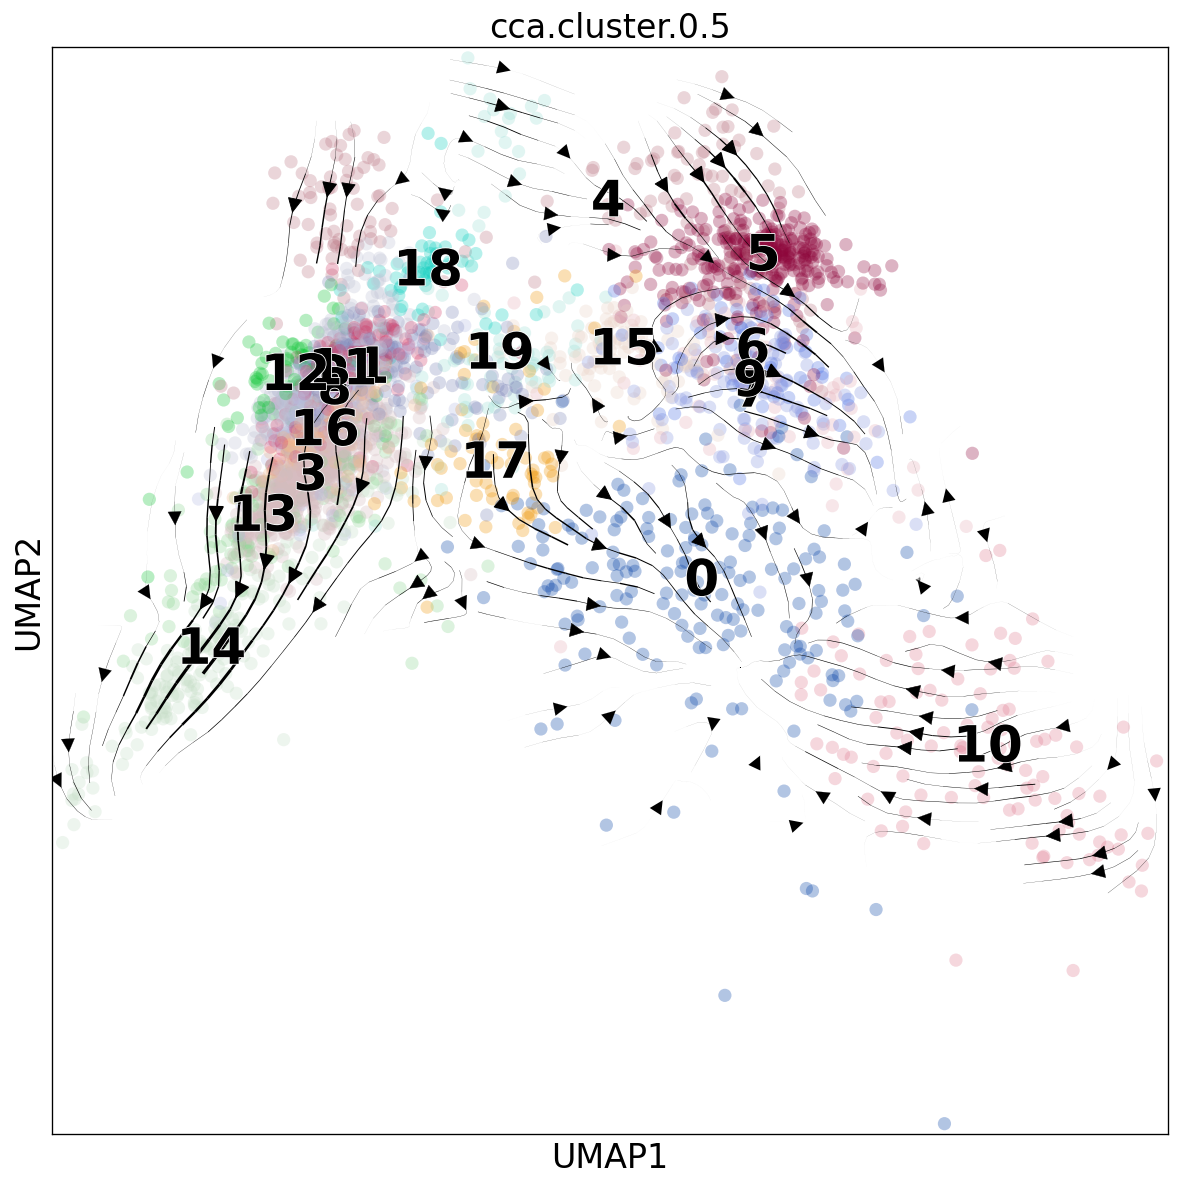